In [1]:
import json

In [2]:
from ipynb.fs.full.quantumsystem import QuantumSystem, qs

In [3]:
class XYLocation(QuantumSystem.System):
    @classmethod
    def get_location(cls, node_id):
        return json.loads(super().get_relationship(node_id))

    @classmethod
    def set_location(cls, node_id, location):
        old_value = super().get_relationship(node_id)
        QuantumSystem.replace(node_id, cls.__name__, old_value, json.dumps(location))
        return json.loads(super().get_relationship(node_id))
    
    @classmethod
    def origin(cls):
        return (0, 0)

In [4]:
class Elevation(QuantumSystem.System):
    pass

In [5]:
class Movement(QuantumSystem.System):
    @classmethod
    def has_jump_jets(cls, unit):
        return cls.get_relationship(unit)[-1] == 'j'
    
    @classmethod
    def get_movement_speed(cls, unit):
        movement = cls.get_relationship(unit)
        return int(movement[:-1]) if movement[-1] == 'j' else int(movement)

In [6]:
class MoveSystem(QuantumSystem.HyperSystem):
    systems = [XYLocation, Elevation, Movement]
    
    @classmethod
    def move(cls, unit, delta):
        movementSpeed = Movement.get_movement_speed(unit)
        startingLocation = XYLocation.get_relationship(unit)
        startingElevation = Elevation.get_relationship(unit)
        startingLocation = json.dumps(json.loads(startingLocation) + [int(startingElevation)])
        deltaDistance = sum([d * d for d in delta]) ** 0.5
        assert deltaDistance < movementSpeed, f"Cannot move unit further ({deltaDistance}) than its movement speed ({movementSpeed})"
        newLocation = [sL + lD for sL, lD in zip(json.loads(startingLocation), delta)]
        xy = newLocation[:1]
        z = newLocation[2]
        QuantumSystem.replace(unit, XYLocation, startingLocation, json.dumps(xy))
        QuantumSystem.replace(unit, Elevation, startingElevation, str(z))

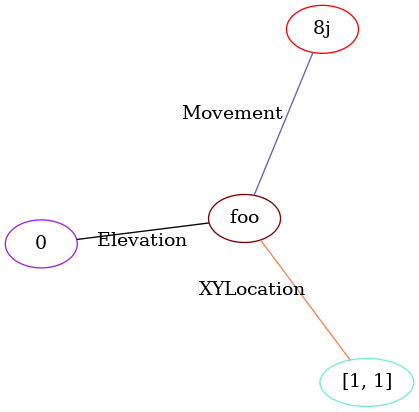

In [7]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()
    MoveSystem.build_system("foo", [json.dumps([1, 1]), "0", "8j"])
    display(qs.render())

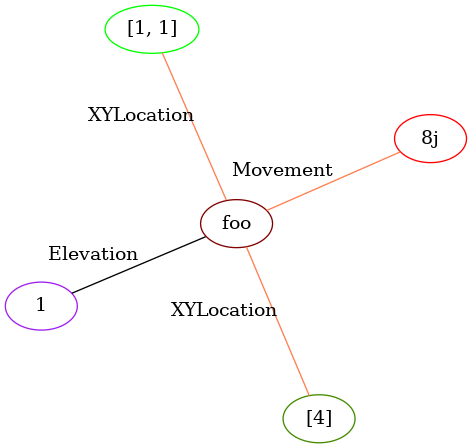

In [8]:
if __name__ == "__main__":
    MoveSystem.move("foo", [3, 2, 1])
    display(qs.render())